In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import joblib
import pickle
from mplsoccer.pitch import Pitch
from ipynb.fs.defs.PassesData import get_df_passes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
plt.style.use('fivethirtyeight')
params = {'axes.titlesize': 'x-large',
          'axes.labelsize': 'large', 
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [3]:
passes = pd.read_excel('extracted_data/passes.xlsx')
matches = pd.read_excel('extracted_data/matches.xlsx')
players = pd.read_excel('extracted_data/players.xlsx')

In [4]:
def get_player_name(player_id):
    if pd.notna(players.loc[players['player_id'] == player_id, 'player_nickname'].iloc[0]):
        return players.loc[players['player_id'] == player_id, 'player_nickname'].iloc[0]
    else:
        return players.loc[players['player_id'] == player_id, 'player_name'].iloc[0]

In [9]:
def get_competition_passes(competition_id):
    comp_matches = matches[matches['competition_id'] == competition_id]
    events_folder = 'data/events'
    events = pd.concat([pd.DataFrame(json.load(open(os.path.join(events_folder, str(match_id) + '.json'), encoding='utf8'))).assign(match_id=match_id) for match_id in comp_matches['match_id'].unique()])
    events.reset_index(inplace=True)
    comp_passes = get_df_passes(events)
    passes_model = joblib.load('models/pass_accuracy_model.pkl')
    with open("models/passes_selected_features.txt", "rb") as fp:
         passes_selected_features = pickle.load(fp)
    comp_passes.loc[:, 'pred_accuracy'] = passes_model.predict_proba(comp_passes[passes_selected_features])[:, 1]
    return comp_passes

In [20]:
# performance evaluation of player's passes
def rate_player_passes(all_passes):
    df_players = pd.DataFrame()
    player_ids = all_passes['player_id'].unique()
    df_players.loc[:, 'player_id'] = player_ids
    df_players.loc[:, 'Spieler'] = [get_player_name(player_id) for player_id in player_ids]
    df_players.loc[:, 'Position'] = [all_passes.loc[all_passes['player_id'] == player_id, 'position'].iloc[0] for player_id in player_ids]
    df_players.loc[:, 'Position'] = ['Torwart' if pos == 1 else 'Verteidiger' if pos <= 8 else 'Mittelfeldspieler' if pos <= 21 else 'Stürmer' for pos in df_players['Position']]
    df_players.loc[:, 'Pässe'] = [len(all_passes[all_passes['player_id'] == player_id]) for player_id in player_ids]
    df_players.loc[:, 'Torschussvorlagen'] = [len(all_passes[(all_passes['player_id'] == player_id) & (all_passes['shot_assist'] == 1)]) for player_id in player_ids]
    df_players.loc[:, 'Torvorlagen'] = [len(all_passes[(all_passes['player_id'] == player_id) & (all_passes['goal_assist'] == 1)]) for player_id in player_ids]
    df_players.loc[:, 'Erwartete Passquote (%)'] = [100 * np.round(all_passes.loc[all_passes['player_id'] == player_id, 'pred_accuracy'].mean(), 4) for player_id in player_ids]
    df_players.loc[:, 'Passquote (%)'] = [100 * np.round(all_passes.loc[all_passes['player_id'] == player_id, 'complete'].mean(), 4) for player_id in player_ids]
    df_players.loc[:, 'Passleistung (%)'] = df_players['Passquote (%)'] - df_players['Erwartete Passquote (%)']
    return df_players

Performace Evaluation on the World Cup 2018

In [11]:
# get pass predictions for the world cup 2018
wc_passes = get_competition_passes(43)

In [21]:
df_players = rate_player_passes(wc_passes)

In [59]:
cols = ['Spieler', 'Pässe', 'Torschussvorlagen', 'Torvorlagen', 'Erwartete Passquote (%)', 'Passquote (%)', 'Passleistung (%)']

In [22]:
df_players[df_players['Pässe'] > 50].sort_values(by='Passleistung (%)', ascending=False)

,player_id,Spieler,Position,Pässe,Torschussvorlagen,Torvorlagen,Erwartete Passquote (%),Passquote (%),Passleistung (%)
177,5601,Vladimir Stojković,Torwart,73,0,0,50.57,64.38,13.81
89,5597,Keylor Navas,Torwart,73,0,0,54.79,64.38,9.59
301,5594,Branislav Ivanović,Verteidiger,102,4,0,65.18,74.51,9.33
255,3099,Hugo Lloris,Torwart,138,0,0,52.51,61.59,9.08
15,3815,Kasper Schmeichel,Torwart,122,0,0,45.98,54.92,8.94
276,5172,Igor Akinfeev,Torwart,114,0,0,33.61,42.11,8.50
298,5739,Vedran Ćorluka,Verteidiger,64,0,0,81.18,89.06,7.88
96,5836,Bryan Oviedo,Verteidiger,64,1,0,71.83,79.69,7.86
105,5547,Alisson,Torwart,67,0,0,74.63,82.09,7.46
110,5837,Douglas Costa,Mittelfeldspieler,52,3,1,73.33,80.77,7.44


In [60]:
df_players.loc[(df_players['Position'] == 'Mittelfeldspieler') & (df_players['Pässe'] > 200), cols].sort_values(by='Passleistung (%)', ascending=False)

,Spieler,Pässe,Torschussvorlagen,Torvorlagen,Erwartete Passquote (%),Passquote (%),Passleistung (%)
132,Toni Kroos,323,7,0,86.08,90.40,4.32
541,Jesse Lingard,228,6,1,87.29,91.23,3.94
103,Neymar,283,23,1,75.34,78.80,3.46
410,Sergio Busquets,312,2,1,88.54,91.99,3.45
406,Koke,270,3,0,88.85,92.22,3.37
432,Abdullah Otayf,257,1,1,87.46,90.66,3.20
309,Axel Witsel,325,1,0,91.22,94.15,2.93
411,Isco,475,10,0,84.32,87.16,2.84
104,Philippe Coutinho,325,11,2,86.67,88.92,2.25
419,Andrés Iniesta,285,6,1,84.96,87.02,2.06


In [64]:
df_players.loc[(df_players['Position'] == 'Verteidiger') & (df_players['Pässe'] > 215) & (df_players['Passleistung (%)'] > 1), cols].sort_values(by='Erwartete Passquote (%)', ascending=True)

,Spieler,Pässe,Torschussvorlagen,Torvorlagen,Erwartete Passquote (%),Passquote (%),Passleistung (%)
288,Mário Fernandes,260,4,1,68.86,72.69,3.83
241,Ricardo Rodríguez,216,7,0,74.25,75.46,1.21
491,Raphaël Guerreiro,252,5,1,76.37,78.57,2.20
324,Thomas Meunier,236,6,2,76.66,80.08,3.42
136,Joshua Kimmich,265,12,0,78.87,82.26,3.39
94,Marcelo,291,8,0,79.35,81.79,2.44
9,Simon Kjær,221,2,0,81.28,86.43,5.15
272,Diego Godín,224,1,0,81.69,83.48,1.79
310,Jan Vertonghen,352,0,0,82.23,84.94,2.71
16,Dejan Lovren,372,1,0,82.24,85.75,3.51


In [53]:
df_players[(df_players['Position'] == 'Verteidiger') & (df_players['Pässe'] > 200)].sort_values(by='Erwartete Passquote (%)', ascending=True)

,player_id,Spieler,Position,Pässe,Torschussvorlagen,Torvorlagen,Erwartete Passquote (%),Passquote (%),Passleistung (%)
288,5170,Mário Fernandes,Verteidiger,260,4,1,68.86,72.69,3.83
60,5691,Johan Mojica,Verteidiger,218,3,0,71.78,67.89,-3.89
241,5544,Ricardo Rodríguez,Verteidiger,216,7,0,74.25,75.46,1.21
271,5248,Martín Cáceres,Verteidiger,257,3,0,74.34,70.04,-4.30
149,5518,Miguel Trauco,Verteidiger,203,2,0,74.34,76.85,2.51
13,5461,Šime Vrsaljko,Verteidiger,374,5,1,75.89,75.67,-0.22
10,5457,Ivan Strinić,Verteidiger,298,3,0,75.98,71.48,-4.50
491,5209,Raphaël Guerreiro,Verteidiger,252,5,1,76.37,78.57,2.20
324,3176,Thomas Meunier,Verteidiger,236,6,2,76.66,80.08,3.42
433,5183,Yasir Al Shahrani,Verteidiger,213,2,0,78.05,79.34,1.29


In [28]:
df_players.loc[df_players['Position'] == 'Torwart', 'Erwartete Passquote (%)'].mean()

59.892682926829266

In [29]:
df_players.loc[df_players['Position'] == 'Verteidiger', 'Erwartete Passquote (%)'].mean()

79.21148148148148

In [30]:
df_players.loc[df_players['Position'] == 'Mittelfeldspieler', 'Erwartete Passquote (%)'].mean()

79.25245614035084

In [31]:
df_players.loc[df_players['Position'] == 'Stürmer', 'Erwartete Passquote (%)'].mean()

72.93400000000001

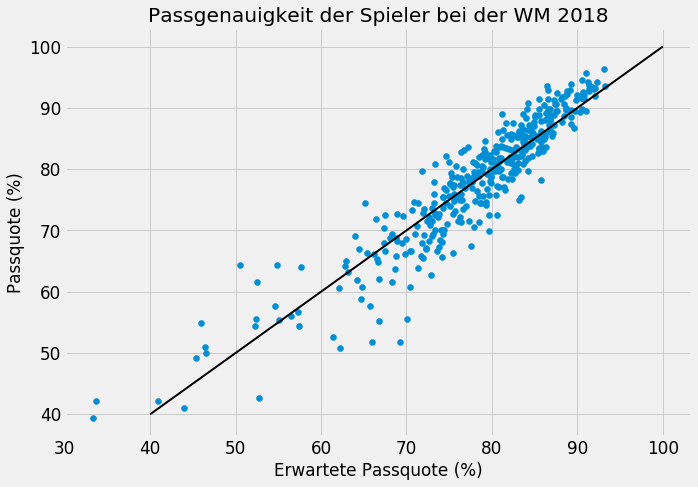

In [43]:
plt.figure(figsize=(10,7))
df_players_lim = df_players[df_players['Pässe'] >= 50]
plt.scatter(df_players_lim['Erwartete Passquote (%)'], df_players_lim['Passquote (%)'])
plt.plot([40,100], [40,100], color='black', linewidth=2)
plt.title('Passgenauigkeit der Spieler bei der WM 2018')
plt.xlabel('Erwartete Passquote (%)')
plt.ylabel('Passquote (%)')
plt.show()